# Financial News & Stock Analysis — Exploratory Data Analysis (EDA)

### Overview
This notebook contains a step-by-step exploratory data analysis of financial news headlines and their relation to stock mentions. The goal is to:

- Understand the structure and quality of the data
- Explore publishing trends over time and by source
- Analyze headline characteristics such as length and content
- Identify top stocks by news volume
- Lay the groundwork for further analyses such as sentiment scoring and correlation with stock prices

### Data Source
The dataset contains financial news headlines, URLs, publishers, publication dates, and referenced stocks.

---

### Approach
We proceed in a systematic way:

1. Load and clean the data
2. Compute basic descriptive statistics
3. Explore article publishing trends over time
4. Analyze top publishers and stocks
5. Prepare for sentiment analysis and integration with stock price data

Each step is implemented in a separate code cell for clarity and reproducibility.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For sentiment analysis (if you want to add later)
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For date/time handling
from datetime import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (only first time)
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')


# Preview the dataset
df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [65]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)

# Remove rows with missing 'date'
df = df[df['date'].notna()]

# Convert date to proper datetime if needed (already parsed above)
df['date'] = pd.to_datetime(df['date'])

# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")

# Drop duplicates if any
df = df.drop_duplicates()

# Check again
df.info()


Duplicates: 0
<class 'pandas.core.frame.DataFrame'>
Index: 55987 entries, 0 to 1407270
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   Unnamed: 0  55987 non-null  int64                    
 1   headline    55987 non-null  object                   
 2   url         55987 non-null  object                   
 3   publisher   55987 non-null  object                   
 4   date        55987 non-null  datetime64[ns, UTC-04:00]
 5   stock       55987 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](1), int64(1), object(4)
memory usage: 3.0+ MB


In [66]:
# Headline length
df['headline_length'] = df['headline'].str.len()

# Summary stats for headline length
print(df['headline_length'].describe())

# Count articles per publisher
publisher_counts = df['publisher'].value_counts().head(10)
print(publisher_counts)


count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


In [67]:
# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by year and month to get article counts
monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='article_count')

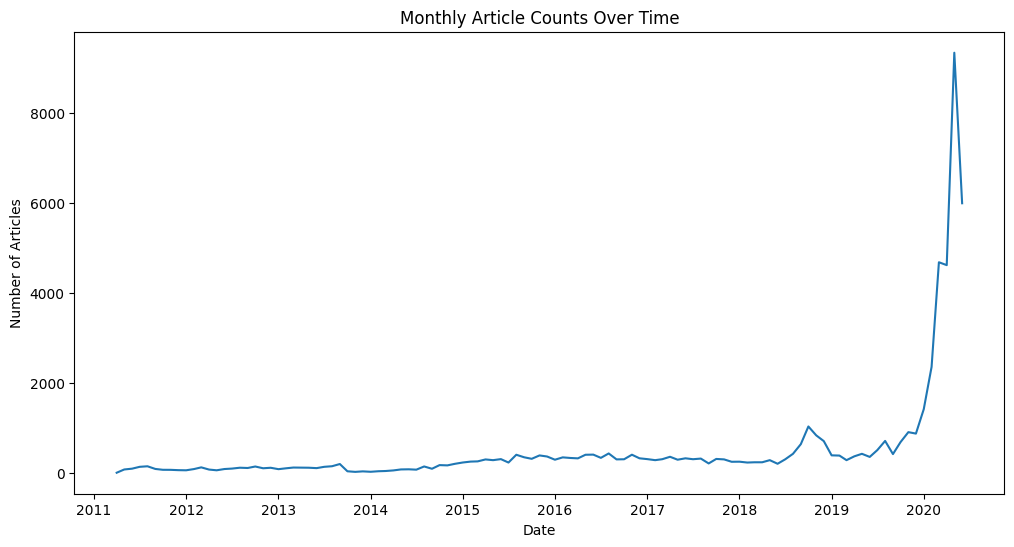

In [68]:
# Plot monthly article counts
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_counts, x=pd.to_datetime(monthly_counts[['year', 'month']].assign(day=1)), y='article_count')
plt.title('Monthly Article Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

In [69]:
df['headline_length'] = df['headline'].str.len()
df['headline_length'].describe()


count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64

In [70]:
print(df['date'].min(), "→", df['date'].max())


2011-04-27 21:01:48-04:00 → 2020-06-11 17:12:35-04:00


<Axes: title={'center': 'Articles Published Per Day'}, xlabel='date'>

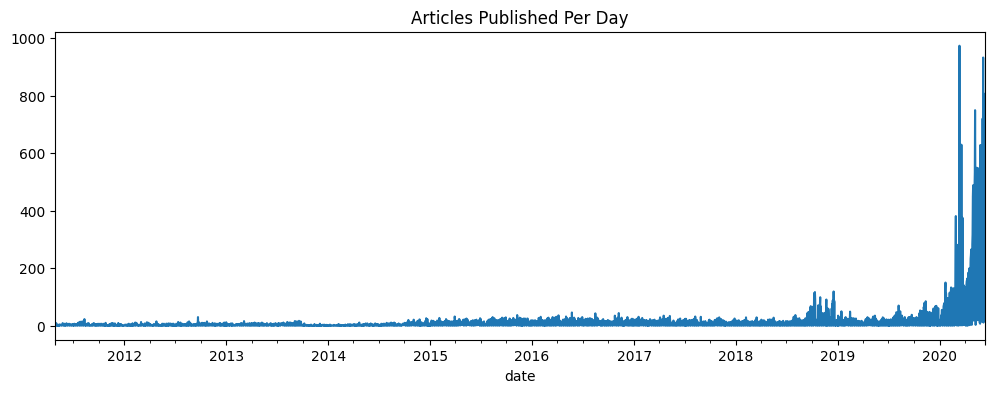

In [71]:
df.set_index('date').resample('D').size().plot(figsize=(12, 4), title='Articles Published Per Day')


<Axes: title={'center': 'Monthly Article Volume'}, xlabel='month'>

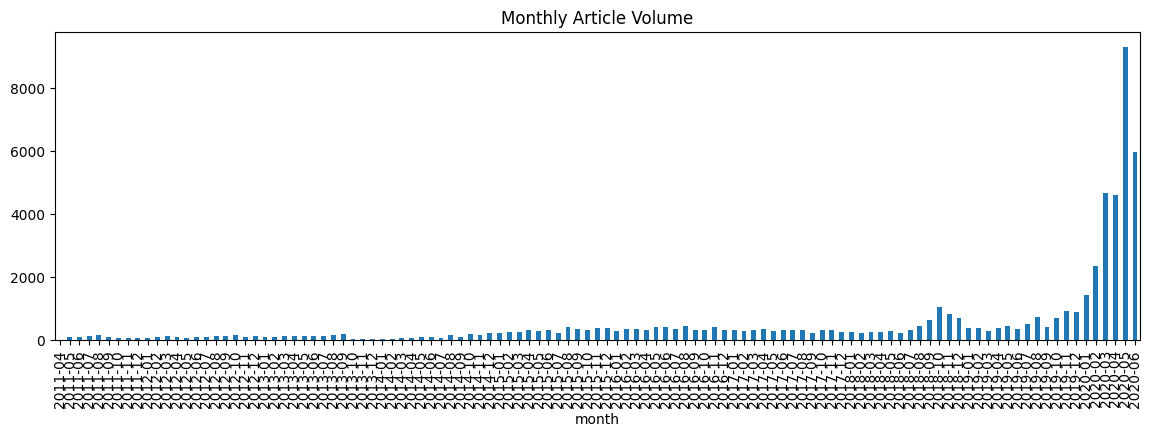

In [72]:
df['month'] = df['date'].dt.to_period('M')
df.groupby('month').size().plot(kind='bar', figsize=(14, 4), title='Monthly Article Volume')


In [76]:
# Apply sentiment analysis on headline column
df['sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [77]:
print(df['sentiment'].describe())

# How many positive/negative/neutral headlines
print("Positive:", (df['sentiment'] > 0).sum())
print("Neutral:", (df['sentiment'] == 0).sum())
print("Negative:", (df['sentiment'] < 0).sum())


count    55987.000000
mean         0.066572
std          0.313522
min         -0.938200
25%          0.000000
50%          0.000000
75%          0.202300
max          0.966600
Name: sentiment, dtype: float64
Positive: 16644
Neutral: 26075
Negative: 13268


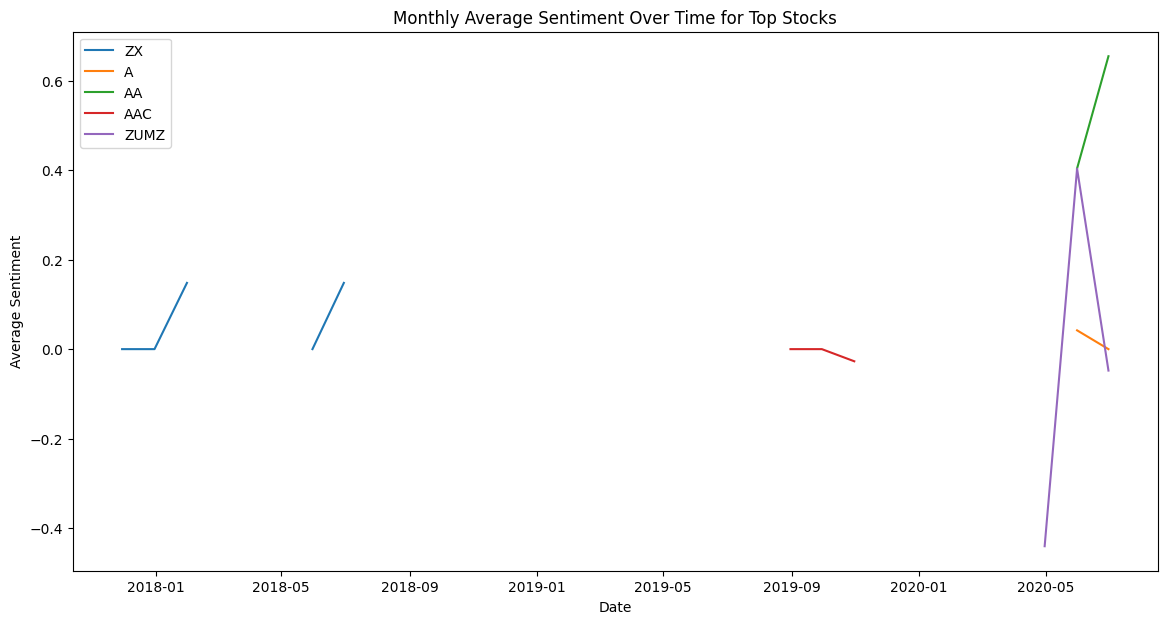

In [78]:
top_stocks = df['stock'].value_counts().head(5).index.tolist()

plt.figure(figsize=(14,7))

for stock in top_stocks:
    stock_df = df[df['stock'] == stock]
    # Resample by month, get mean sentiment
    monthly_sentiment = stock_df.set_index('date').resample('M')['sentiment'].mean()
    plt.plot(monthly_sentiment.index, monthly_sentiment, label=stock)

plt.title("Monthly Average Sentiment Over Time for Top Stocks")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.show()


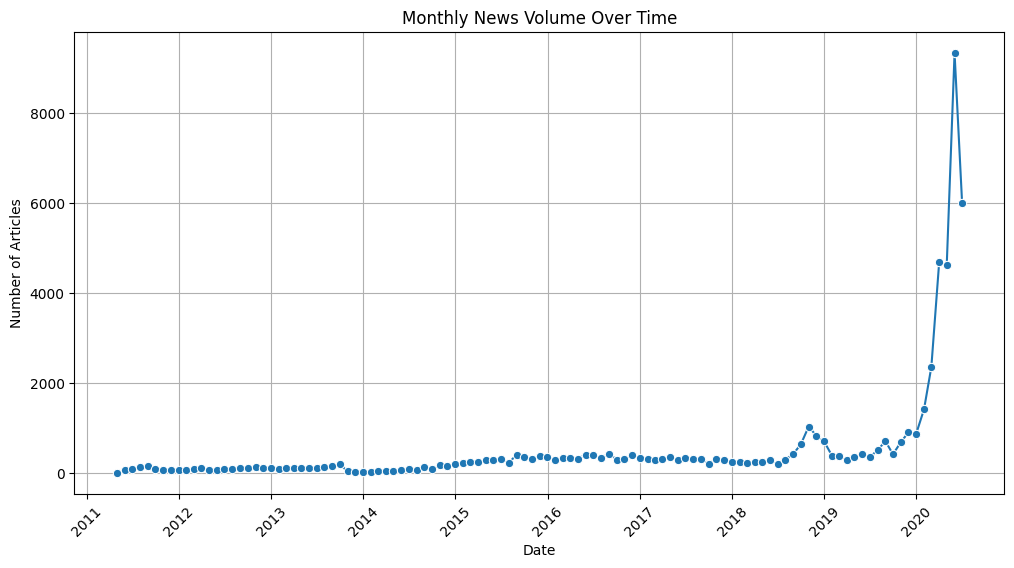

In [82]:
# Group by month and count articles
monthly_news_volume = df.groupby(pd.Grouper(key='date', freq='M')).size()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_news_volume.index, y=monthly_news_volume.values, marker="o")
plt.title("Monthly News Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

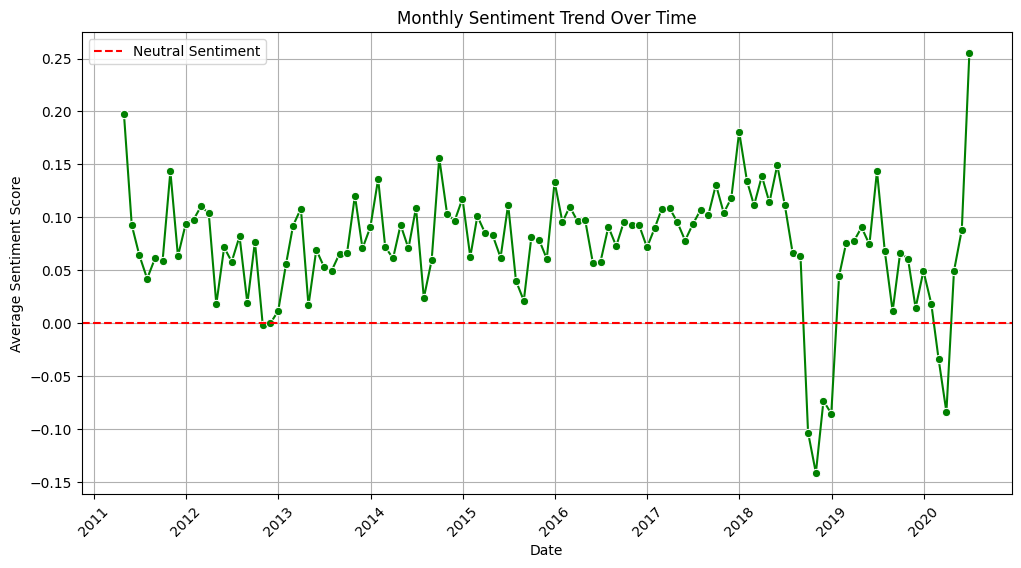

In [83]:
# Compute average sentiment per month
monthly_sentiment = df.groupby(pd.Grouper(key='date', freq='M'))['sentiment'].mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_sentiment.index, y=monthly_sentiment.values, marker="o", color="green")
plt.title("Monthly Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
plt.legend()
plt.grid(True)
plt.show()

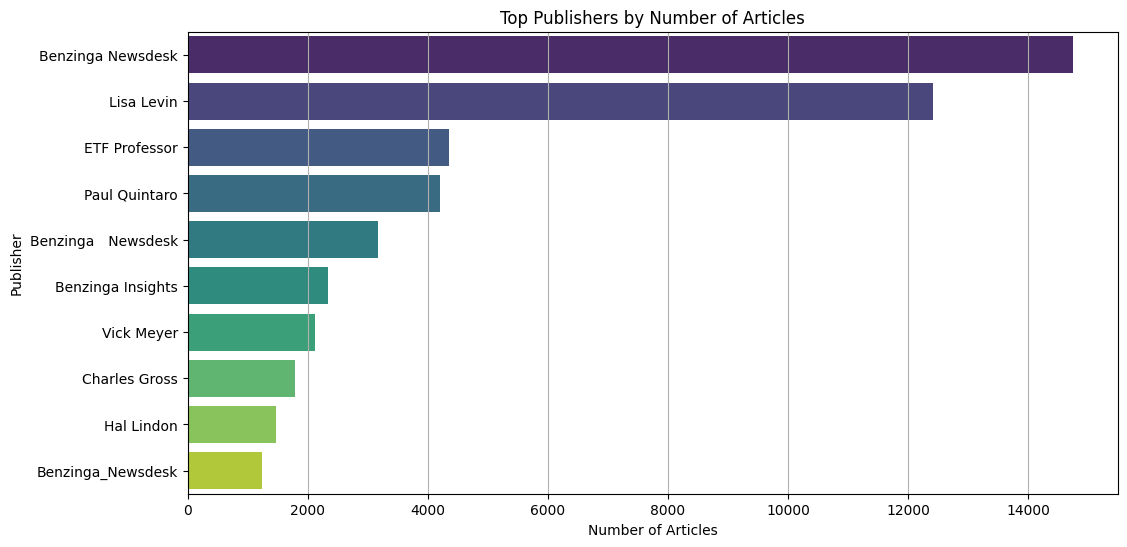

In [84]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts().head(10)  # Top 10 publishers

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(y=publisher_counts.index, x=publisher_counts.values, palette="viridis")
plt.title("Top Publishers by Number of Articles")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.grid(axis="x")
plt.show()
